# Setup Kaggle API (Upload kaggle.json and Install)


In [1]:
from google.colab import files
import os, json, shutil, zipfile

print("ارفع kaggle.json (من حسابك: Account > Create New API Token)")
uploaded = files.upload()
assert 'kaggle.json' in uploaded, "  kaggle.json"

os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)
with open(os.path.expanduser("~/.kaggle/kaggle.json"), "wb") as f:
    f.write(uploaded['kaggle.json'])

os.chmod(os.path.expanduser("~/.kaggle/kaggle.json"), 0o600)

!pip -q install kaggle
print(" ✅ kaggle جاهز ")


ارفع kaggle.json (من حسابك: Account > Create New API Token)


Saving kaggle.json to kaggle.json
✅ kaggle جاهز


# Download and Extract MRI Segmentation Dataset from Kaggle


In [2]:
# المصدر: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
dataset_slug = "mateuszbuda/lgg-mri-segmentation"
target_dir   = "data/lgg"

os.makedirs(target_dir, exist_ok=True)
!kaggle datasets download -d {dataset_slug} -p {target_dir} --force
# هنفك أي ملفات zip موجودة
for fname in os.listdir(target_dir):
    if fname.endswith(".zip"):
        with zipfile.ZipFile(os.path.join(target_dir, fname), 'r') as z:
            z.extractall(target_dir)
        os.remove(os.path.join(target_dir, fname))

print("📂 الملفات داخل:", target_dir)
print(os.listdir(target_dir)[:20])


Dataset URL: https://www.kaggle.com/datasets/mateuszbuda/lgg-mri-segmentation
License(s): CC-BY-NC-SA-4.0
 96% 685M/714M [00:03<00:00, 46.5MB/s]
100% 714M/714M [00:03<00:00, 192MB/s] 
📂 الملفات داخل: data/lgg
['kaggle_3m', 'lgg-mri-segmentation']


# Install Dependencies and Set Global Parameters


In [3]:
!pip -q install pillow==10.4.0 opencv-python==4.10.0.84

import os, random, glob, math
import numpy as np
from PIL import Image
import cv2
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, backend as K
import matplotlib.pyplot as plt

SEED         = 1337
IMG_SIZE     = 256
BATCH_SIZE   = 8
VAL_SPLIT    = 0.15
TEST_SPLIT   = 0.15
EPOCHS       = 60
BEST_DIR     = "checkpoints"
os.makedirs(BEST_DIR, exist_ok=True)
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

print(tf.__version__)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 66.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 MB 12.2 MB/s eta 0:00:00
2.19.0


# Load Image & Mask Paths and Split Dataset (Train/Val/Test)


In [4]:

root = "data/lgg"

mask_paths = sorted(glob.glob(os.path.join(root, "**", "*_mask.tif"), recursive=True))
image_paths = []
for mp in mask_paths:
    ip = mp.replace("_mask.tif", ".tif")
    if os.path.exists(ip):
        image_paths.append(ip)

print("عدد الصور:", len(image_paths), "عدد الماسكات:", len(mask_paths))
assert len(image_paths) > 0 and len(image_paths) == len(mask_paths), "تأكد إن الملفات اتفكت صح"

idx = list(range(len(image_paths)))
random.shuffle(idx)
image_paths = [image_paths[i] for i in idx]
mask_paths  = [mask_paths[i]  for i in idx]

n = len(image_paths)
n_test = int(TEST_SPLIT * n)
n_val  = int(VAL_SPLIT  * n)
n_train = n - n_val - n_test

train_imgs = image_paths[:n_train]; train_msks = mask_paths[:n_train]
val_imgs   = image_paths[n_train:n_train+n_val]; val_msks = mask_paths[n_train:n_train+n_val]
test_imgs  = image_paths[n_train+n_val:]; test_msks = mask_paths[n_train+n_val:]

len(train_imgs), len(val_imgs), len(test_imgs)


عدد الصور: 7858 عدد الماسكات: 7858


(5502, 1178, 1178)

# Data Loading, Augmentation, and Custom Data Generator


In [11]:
def load_pair(img_path, msk_path, size=IMG_SIZE):
    # نقرأ الصورة جراي سكيل بالـ cv2
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    msk = cv2.imread(msk_path, cv2.IMREAD_GRAYSCALE)

    # resize
    img = cv2.resize(img, (size, size), interpolation=cv2.INTER_LINEAR)
    msk = cv2.resize(msk, (size, size), interpolation=cv2.INTER_NEAREST)

    # normalize
    img = img.astype(np.float32) / 255.0
    msk = (msk.astype(np.float32) / 255.0)
    msk = (msk > 0.5).astype(np.float32)

    # add channel dimension
    img = np.expand_dims(img, -1)
    msk = np.expand_dims(msk, -1)

    return img, msk


def augment(img, msk):
    # قلب افقي
    if random.random() < 0.5:
        img = np.flip(img, axis=1)
        msk = np.flip(msk, axis=1)
    # قلب رأسي
    if random.random() < 0.2:
        img = np.flip(img, axis=0)
        msk = np.flip(msk, axis=0)
    # تدوير 90/180/270 باحتمال بسيط
    if random.random() < 0.2:
        k = random.choice([1,2,3])
        img = np.rot90(img, k, axes=(0,1))
        msk = np.rot90(msk, k, axes=(0,1))
    return img.copy(), msk.copy()

class SegDataGen(keras.utils.Sequence):
    def __init__(self, img_paths, msk_paths, batch_size=BATCH_SIZE, augmenting=False):
        self.img_paths = img_paths
        self.msk_paths = msk_paths
        self.batch_size = batch_size
        self.augmenting = augmenting
        self.indexes = np.arange(len(self.img_paths))
    def __len__(self):
        return math.ceil(len(self.img_paths) / self.batch_size)
    def __getitem__(self, i):
        batch_idx = self.indexes[i*self.batch_size : (i+1)*self.batch_size]
        X, Y = [], []
        for j in batch_idx:
            img, msk = load_pair(self.img_paths[j], self.msk_paths[j])
            if self.augmenting:
                img, msk = augment(img, msk)
            X.append(img); Y.append(msk)
        return np.stack(X,0), np.stack(Y,0)
    def on_epoch_end(self):
        np.random.shuffle(self.indexes)

train_gen = SegDataGen(train_imgs, train_msks, augmenting=True)
val_gen   = SegDataGen(val_imgs, val_msks, augmenting=False)
test_gen  = SegDataGen(test_imgs, test_msks, augmenting=False)


# Build and Compile U-Net Model with Dice Loss


In [12]:
def conv_block(x, f):
    x = layers.Conv2D(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.Conv2D(f, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    return x

def encoder_block(x, f):
    c = conv_block(x, f)
    p = layers.MaxPooling2D((2,2))(c)
    return c, p

def decoder_block(x, skip, f):
    x = layers.Conv2DTranspose(f, 2, strides=2, padding="same")(x)
    x = layers.Concatenate()([x, skip])
    x = conv_block(x, f)
    return x

def build_unet(img_size=IMG_SIZE):
    inputs = layers.Input((img_size, img_size, 1))
    c1, p1 = encoder_block(inputs, 32)
    c2, p2 = encoder_block(p1, 64)
    c3, p3 = encoder_block(p2, 128)
    c4, p4 = encoder_block(p3, 256)
    bn = conv_block(p4, 512)
    d1 = decoder_block(bn, c4, 256)
    d2 = decoder_block(d1, c3, 128)
    d3 = decoder_block(d2, c2, 64)
    d4 = decoder_block(d3, c1, 32)
    outputs = layers.Conv2D(1, 1, activation="sigmoid")(d4)
    return keras.Model(inputs, outputs, name="UNet")

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2.*intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

model = build_unet()
model.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss=dice_loss,
    metrics=[dice_coef, keras.metrics.BinaryAccuracy(name="bin_acc", threshold=0.5)]
)
model.summary()


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 256, 256,  │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_19[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_18       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 256, 256,  │      9,248 │ activation_18[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        128 │ conv2d_20[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 128, 128,  │          0 │ activation_19[0]… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 128, 128,  │     18,496 │ max_pooling2d_4[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_21[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 128, 128,  │     36,928 │ activation_20[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        256 │ conv2d_22[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (None, 64, 64,    │          0 │ activation_21[0]… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 64, 64,    │     73,856 │ max_pooling2d_5[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │        512 │ conv2d_23[0][0] 

 Total params: 7,771,297 (29.65 MB)

 Trainable params: 7,765,409 (29.62 MB)

 Non-trainable params: 5,888 (23.00 KB)

# Define Training Callbacks (Checkpoint, EarlyStopping, StopAtValDice)


In [13]:
class StopAtValDice(keras.callbacks.Callback):
    def __init__(self, target=0.95):
        super().__init__()
        self.target = target
    def on_epoch_end(self, epoch, logs=None):
        val_dice = logs.get("val_dice_coef", 0.0)
        if val_dice >= self.target:
            print(f"\n🎯 وصلت ل Dice {val_dice:.4f} ≥ {self.target}, هنوقف التدريب.")
            self.model.stop_training = True

ckpt_path = os.path.join(BEST_DIR, "unet_lgg_best.h5")
callbacks = [
    keras.callbacks.ModelCheckpoint(
        ckpt_path, monitor="val_dice_coef", mode="max",
        save_best_only=True, save_weights_only=False, verbose=1
    ),
    keras.callbacks.EarlyStopping(
        monitor="val_dice_coef", mode="max", patience=10, restore_best_weights=True, verbose=1
    ),
    StopAtValDice(target=0.95)
]


# Train Model and Load Best Checkpoint


In [14]:
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks,
    verbose=1
)

best_model = keras.models.load_model(
    ckpt_path,
    custom_objects={"dice_loss": dice_loss, "dice_coef": dice_coef}
)
print("✅ Loaded best model from:", ckpt_path)


Epoch 1/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - bin_acc: 0.9338 - dice_coef: 0.1637 - loss: 0.8361
Epoch 1: val_dice_coef improved from -inf to 0.23100, saving model to checkpoints/unet_lgg_best.h5


688/688 ━━━━━━━━━━━━━━━━━━━━ 193s 222ms/step - bin_acc: 0.9338 - dice_coef: 0.1638 - loss: 0.8360 - val_bin_acc: 0.9893 - val_dice_coef: 0.2310 - val_loss: 0.7678
Epoch 2/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9866 - dice_coef: 0.3195 - loss: 0.6804
Epoch 2: val_dice_coef did not improve from 0.23100
688/688 ━━━━━━━━━━━━━━━━━━━━ 123s 179ms/step - bin_acc: 0.9866 - dice_coef: 0.3195 - loss: 0.6804 - val_bin_acc: 0.9414 - val_dice_coef: 0.1390 - val_loss: 0.8603
Epoch 3/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9872 - dice_coef: 0.3342 - loss: 0.6659
Epoch 3: val_dice_coef improved from 0.23100 to 0.32016, saving model to checkpoints/unet_lgg_best.h5


688/688 ━━━━━━━━━━━━━━━━━━━━ 122s 177ms/step - bin_acc: 0.9872 - dice_coef: 0.3342 - loss: 0.6659 - val_bin_acc: 0.9904 - val_dice_coef: 0.3202 - val_loss: 0.6782
Epoch 4/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9881 - dice_coef: 0.3436 - loss: 0.6565
Epoch 4: val_dice_coef did not improve from 0.32016
688/688 ━━━━━━━━━━━━━━━━━━━━ 141s 175ms/step - bin_acc: 0.9881 - dice_coef: 0.3436 - loss: 0.6565 - val_bin_acc: 0.9713 - val_dice_coef: 0.2576 - val_loss: 0.7425
Epoch 5/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9891 - dice_coef: 0.3765 - loss: 0.6236
Epoch 5: val_dice_coef did not improve from 0.32016
688/688 ━━━━━━━━━━━━━━━━━━━━ 120s 175ms/step - bin_acc: 0.9891 - dice_coef: 0.3765 - loss: 0.6236 - val_bin_acc: 0.9465 - val_dice_coef: 0.1941 - val_loss: 0.8049
Epoch 6/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - bin_acc: 0.9892 - dice_coef: 0.4106 - loss: 0.5895
Epoch 6: val_dice_coef improved from 0.32016 to 0.40606, saving model to checkpoints/u

688/688 ━━━━━━━━━━━━━━━━━━━━ 120s 175ms/step - bin_acc: 0.9892 - dice_coef: 0.4106 - loss: 0.5895 - val_bin_acc: 0.9924 - val_dice_coef: 0.4061 - val_loss: 0.5919
Epoch 7/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9912 - dice_coef: 0.4644 - loss: 0.5357
Epoch 7: val_dice_coef did not improve from 0.40606
688/688 ━━━━━━━━━━━━━━━━━━━━ 120s 175ms/step - bin_acc: 0.9912 - dice_coef: 0.4644 - loss: 0.5357 - val_bin_acc: 0.9883 - val_dice_coef: 0.3801 - val_loss: 0.6179
Epoch 8/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9913 - dice_coef: 0.4912 - loss: 0.5088
Epoch 8: val_dice_coef did not improve from 0.40606
688/688 ━━━━━━━━━━━━━━━━━━━━ 142s 175ms/step - bin_acc: 0.9913 - dice_coef: 0.4912 - loss: 0.5088 - val_bin_acc: 0.9919 - val_dice_coef: 0.3004 - val_loss: 0.6980
Epoch 9/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9921 - dice_coef: 0.5339 - loss: 0.4662
Epoch 9: val_dice_coef did not improve from 0.40606
688/688 ━━━━━━━━━━━━━━━━━━━━ 124s 

688/688 ━━━━━━━━━━━━━━━━━━━━ 120s 175ms/step - bin_acc: 0.9920 - dice_coef: 0.5225 - loss: 0.4775 - val_bin_acc: 0.9839 - val_dice_coef: 0.4417 - val_loss: 0.5560
Epoch 11/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9927 - dice_coef: 0.5790 - loss: 0.4210
Epoch 11: val_dice_coef improved from 0.44170 to 0.50717, saving model to checkpoints/unet_lgg_best.h5


688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - bin_acc: 0.9927 - dice_coef: 0.5790 - loss: 0.4210 - val_bin_acc: 0.9903 - val_dice_coef: 0.5072 - val_loss: 0.4902
Epoch 12/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9924 - dice_coef: 0.5878 - loss: 0.4122
Epoch 12: val_dice_coef did not improve from 0.50717
688/688 ━━━━━━━━━━━━━━━━━━━━ 120s 175ms/step - bin_acc: 0.9924 - dice_coef: 0.5878 - loss: 0.4122 - val_bin_acc: 0.9931 - val_dice_coef: 0.4558 - val_loss: 0.5418
Epoch 13/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - bin_acc: 0.9927 - dice_coef: 0.5747 - loss: 0.4254
Epoch 13: val_dice_coef did not improve from 0.50717
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 175ms/step - bin_acc: 0.9928 - dice_coef: 0.5747 - loss: 0.4253 - val_bin_acc: 0.9850 - val_dice_coef: 0.4570 - val_loss: 0.5447
Epoch 14/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9932 - dice_coef: 0.6118 - loss: 0.3882
Epoch 14: val_dice_coef improved from 0.50717 to 0.53974, saving model to checkpo

688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 177ms/step - bin_acc: 0.9932 - dice_coef: 0.6117 - loss: 0.3882 - val_bin_acc: 0.9944 - val_dice_coef: 0.5397 - val_loss: 0.4616
Epoch 15/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9940 - dice_coef: 0.6243 - loss: 0.3757
Epoch 15: val_dice_coef improved from 0.53974 to 0.57124, saving model to checkpoints/unet_lgg_best.h5


688/688 ━━━━━━━━━━━━━━━━━━━━ 122s 177ms/step - bin_acc: 0.9940 - dice_coef: 0.6243 - loss: 0.3757 - val_bin_acc: 0.9936 - val_dice_coef: 0.5712 - val_loss: 0.4299
Epoch 16/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9940 - dice_coef: 0.6210 - loss: 0.3790
Epoch 16: val_dice_coef did not improve from 0.57124
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9940 - dice_coef: 0.6210 - loss: 0.3790 - val_bin_acc: 0.9943 - val_dice_coef: 0.5396 - val_loss: 0.4576
Epoch 17/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9938 - dice_coef: 0.6055 - loss: 0.3945
Epoch 17: val_dice_coef did not improve from 0.57124
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9938 - dice_coef: 0.6056 - loss: 0.3944 - val_bin_acc: 0.9940 - val_dice_coef: 0.5266 - val_loss: 0.4750
Epoch 18/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9946 - dice_coef: 0.6658 - loss: 0.3343
Epoch 18: val_dice_coef did not improve from 0.57124
688/688 ━━━━━━━━━━━━━━━━━━━━

688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 177ms/step - bin_acc: 0.9944 - dice_coef: 0.6468 - loss: 0.3532 - val_bin_acc: 0.9950 - val_dice_coef: 0.6157 - val_loss: 0.3859
Epoch 20/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9945 - dice_coef: 0.6508 - loss: 0.3493
Epoch 20: val_dice_coef did not improve from 0.61567
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9945 - dice_coef: 0.6508 - loss: 0.3493 - val_bin_acc: 0.9944 - val_dice_coef: 0.5563 - val_loss: 0.4454
Epoch 21/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9948 - dice_coef: 0.6773 - loss: 0.3227
Epoch 21: val_dice_coef improved from 0.61567 to 0.62788, saving model to checkpoints/unet_lgg_best.h5


688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9948 - dice_coef: 0.6773 - loss: 0.3227 - val_bin_acc: 0.9951 - val_dice_coef: 0.6279 - val_loss: 0.3709
Epoch 22/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9952 - dice_coef: 0.6951 - loss: 0.3048
Epoch 22: val_dice_coef did not improve from 0.62788
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9952 - dice_coef: 0.6951 - loss: 0.3048 - val_bin_acc: 0.9932 - val_dice_coef: 0.5364 - val_loss: 0.4645
Epoch 23/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9947 - dice_coef: 0.6756 - loss: 0.3244
Epoch 23: val_dice_coef did not improve from 0.62788
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9947 - dice_coef: 0.6756 - loss: 0.3244 - val_bin_acc: 0.9924 - val_dice_coef: 0.3152 - val_loss: 0.6842
Epoch 24/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9953 - dice_coef: 0.6841 - loss: 0.3160
Epoch 24: val_dice_coef improved from 0.62788 to 0.63309, saving model to checkpo

688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9953 - dice_coef: 0.6841 - loss: 0.3159 - val_bin_acc: 0.9951 - val_dice_coef: 0.6331 - val_loss: 0.3637
Epoch 25/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9954 - dice_coef: 0.7000 - loss: 0.2995
Epoch 25: val_dice_coef improved from 0.63309 to 0.67188, saving model to checkpoints/unet_lgg_best.h5


688/688 ━━━━━━━━━━━━━━━━━━━━ 125s 181ms/step - bin_acc: 0.9954 - dice_coef: 0.7000 - loss: 0.2995 - val_bin_acc: 0.9958 - val_dice_coef: 0.6719 - val_loss: 0.3247
Epoch 26/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9951 - dice_coef: 0.6783 - loss: 0.3215
Epoch 26: val_dice_coef improved from 0.67188 to 0.70586, saving model to checkpoints/unet_lgg_best.h5


688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9951 - dice_coef: 0.6783 - loss: 0.3215 - val_bin_acc: 0.9959 - val_dice_coef: 0.7059 - val_loss: 0.2954
Epoch 27/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9951 - dice_coef: 0.7071 - loss: 0.2929
Epoch 27: val_dice_coef did not improve from 0.70586
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9951 - dice_coef: 0.7071 - loss: 0.2929 - val_bin_acc: 0.9959 - val_dice_coef: 0.6941 - val_loss: 0.3064
Epoch 28/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9951 - dice_coef: 0.6838 - loss: 0.3161
Epoch 28: val_dice_coef did not improve from 0.70586
688/688 ━━━━━━━━━━━━━━━━━━━━ 121s 176ms/step - bin_acc: 0.9951 - dice_coef: 0.6839 - loss: 0.3161 - val_bin_acc: 0.9935 - val_dice_coef: 0.4773 - val_loss: 0.5203
Epoch 29/60
688/688 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step - bin_acc: 0.9958 - dice_coef: 0.7154 - loss: 0.2846
Epoch 29: val_dice_coef did not improve from 0.70586
688/688 ━━━━━━━━━━━━━━━━━━━━

✅ Loaded best model from: checkpoints/unet_lgg_best.h5


# Evaluate Model on Test Set (Dice, IoU, Accuracy)


In [42]:
def iou_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.reshape(-1)
    y_pred_f = y_pred.reshape(-1)
    inter = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - inter
    return (inter + smooth) / (union + smooth)

dice_list, acc_list, iou_list = [], [], []

for i in range(len(test_gen)):
    x, y = test_gen[i]
    if x is None or len(x) == 0:
        continue
    yp = best_model.predict(x, verbose=0)
    yp_bin = (yp > 0.5).astype(np.float32)

    # Dice
    num = 2.0*np.sum(y*yp_bin) + 1e-6
    den = np.sum(y) + np.sum(yp_bin) + 1e-6
    dice_list.append(num/den)

    # Accuracy
    acc_list.append(np.mean((yp_bin == y).astype(np.float32)))

    # IoU
    iou_list.append(iou_coef(y, yp_bin))

print(f"Test Dice: {np.mean(dice_list):.4f}")
print(f"Test IoU : {np.mean(iou_list):.4f}")
print(f"Test Acc : {np.mean(acc_list)*100:.2f}%")


Test Dice: 0.7161
Test IoU : 0.5979
Test Acc : 99.58%


# Visualize Prediction (Input, Predicted Mask, Tumor Region)


🖼 Saved to: outputs/input.png, outputs/pred_mask.png, outputs/tumor_only.png


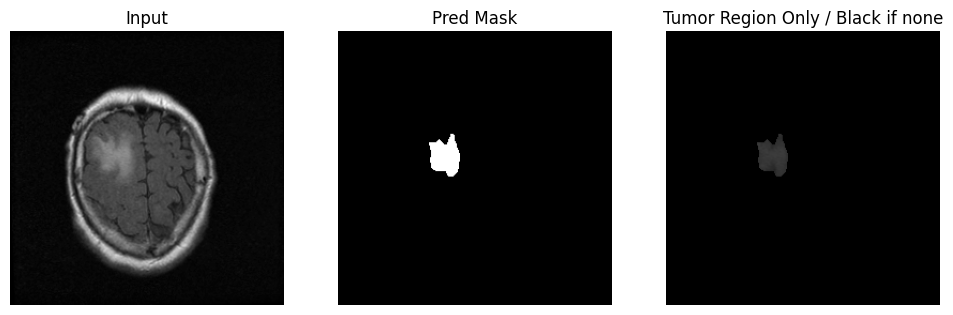

In [39]:
import matplotlib.pyplot as plt

rnd = random.randrange(len(test_imgs))
img_path = test_imgs[rnd]
msk_path = test_msks[rnd]

img, msk = load_pair(img_path, msk_path)
pred = best_model.predict(np.expand_dims(img,0), verbose=0)[0]
pred_bin = (pred > 0.5).astype(np.float32)

# "صورة الجزء المصاب فقط": نضرب الصورة في الماسك الثنائي
tumor_only = img * pred_bin  # (H,W,1)
tumor_only_3 = np.repeat(tumor_only, 3, axis=-1)

# لو الماسك فاضي بالكامل، نرجّع صورة سودة
if tumor_only.sum() == 0:
    out = np.zeros((IMG_SIZE, IMG_SIZE, 3), dtype=np.float32)
else:
    out = tumor_only_3

# حفظ النتائج
os.makedirs("outputs", exist_ok=True)
Image.fromarray((img.squeeze()*255).astype(np.uint8)).save("outputs/input.png")
Image.fromarray((pred_bin.squeeze()*255).astype(np.uint8)).save("outputs/pred_mask.png")
Image.fromarray((out*255).astype(np.uint8)).save("outputs/tumor_only.png")

print("🖼 Saved to: outputs/input.png, outputs/pred_mask.png, outputs/tumor_only.png")

# عرض سريع
plt.figure(figsize=(12,4))
plt.subplot(1,3,1); plt.title("Input"); plt.imshow(img.squeeze(), cmap='gray'); plt.axis('off')
plt.subplot(1,3,2); plt.title("Pred Mask"); plt.imshow(pred_bin.squeeze(), cmap='gray'); plt.axis('off')
plt.subplot(1,3,3); plt.title("Tumor Region Only / Black if none"); plt.imshow(out.squeeze(), cmap='gray'); plt.axis('off')
plt.show()


# Save and Download Trained U-Net Model


In [ ]:

best_model.save("brain_tumor_unet.h5")

from google.colab import files
files.download("brain_tumor_unet.h5")
files.download("brain_tumor_unet_savedmodel.zip")


In [45]:
best_model.save("brain_tumor_unet.keras")
files.download("brain_tumor_unet.keras")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [46]:
best_model.export("brain_tumor_unet_savedmodel")

best_model.save("brain_tumor_unet.h5")
files.download("brain_tumor_unet.h5")

Saved artifact at 'brain_tumor_unet_savedmodel'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): List[TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name='input_layer_1')]
Output Type:
  TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None)
Captures:
  140533813553168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140533822142032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140533813553552: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531938132048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140533822140304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140533813553744: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531938146832: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531938146640: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531938147024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  140531938148176: TensorSpec(shape=(), dtype=tf.resource,

In [47]:
files.download("brain_tumor_unet_savedmodel")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>